# Header

In [65]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline

# Load Data

In [83]:
gold_prices = pd.read_csv("./data/daily.csv")

In [84]:
gold_prices.head()

,Date,Price
0,1997-01-07,3.82
1,1997-01-08,3.80
2,1997-01-09,3.61
3,1997-01-10,3.92
4,1997-01-13,4.00


In [85]:
gold_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5480 entries, 0 to 5479
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5480 non-null   object 
 1   Price   5479 non-null   float64
dtypes: float64(1), object(1)
memory usage: 85.8+ KB


In [86]:
# Convert Date to datetime for plotting
gold_prices = gold_prices.astype({"Date": "datetime64[ns]"})

# Missing Data

## Nans

In [87]:
gold_prices[gold_prices.Price.isna()]

,Date,Price
5284,2018-01-05,NaN


Let's look around the missing point.

From the graph below it looks like there are also some other missing points. Likely from missing (date, price) tuples.

<Axes: xlabel='Date'>

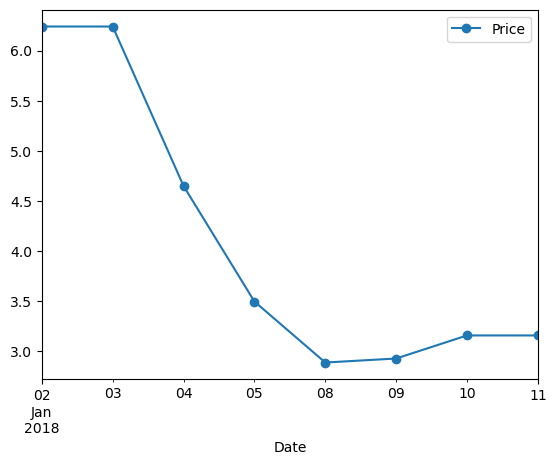

In [91]:
(
    gold_prices[
        gold_prices.Date.dt.date.between(
            dt.date(2018, 1, 1),
            dt.date(2018, 1, 11)
        )
    ]
    .plot(
        kind='line',
        x='Date',
        y='Price',
        marker='o'
    )
)

### Interpolate to fill nans

In [58]:
surronding_values = (
    gold_prices[
        gold_prices.Date.dt.date.between(
            dt.date(2018, 1, 3),
            dt.date(2018, 1, 9)
        )
    ]
    .Price
    .dropna()
    .values
)
xs = np.array([0,1,3,4])  # Notice that 2 is missing, that's the day we want to impute

In [61]:
cs = CubicSpline(xs, surronding_values)

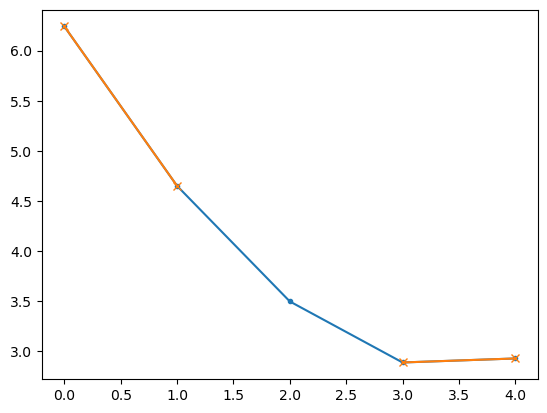

In [80]:
prices = gold_prices[
    gold_prices.Date.dt.date.between(
        dt.date(2018, 1, 3),
        dt.date(2018, 1, 9)
    )
].Price
all_xs = np.arange(0,5)

fig, ax = plt.subplots()

ax.plot(all_xs, cs(all_xs), '.-')
ax.plot(all_xs, prices, 'x-')

Above is the graph including the extrapolation. Looks good to me! If there were more missing data, we would do something more 

Now that we know the interpolation is decent, let's add it to the dataset.

In [90]:
gold_prices.loc[gold_prices.Date.dt.date == dt.date(2018, 1, 5), 'Price'] = cs(2)

## Missing Dates

Take the difference between dates for neighboring rows and look for diffs that are greater than on day. Now that I'm thinking about this, it's possible the missing dates are weekends or holidays. Let's continue on investigating.

In [37]:
temp_df = gold_prices[['Date']].copy()
temp_df['day_diff'] = temp_df.Date.diff().dt.days
temp_df['weekday'] = temp_df.Date.dt.weekday

In [38]:
temp_df.head()

,Date,day_diff,weekday
0,1997-01-07,NaN,1
1,1997-01-08,1.0,2
2,1997-01-09,1.0,3
3,1997-01-10,1.0,4
4,1997-01-13,3.0,0


Looks like 0 is monday ... 6 is sunday. What is the distributino of days? It looks like I was correct, days 5 and 6 are completely absent, indicating that weekends are not included.

In [39]:
(
    temp_df
    .groupby('weekday')
    .count()
)

,Date,day_diff
weekday,,
0,1038,1038
1,1126,1125
2,1126,1126
3,1106,1106
4,1084,1084


In [40]:
(
    temp_df
    .groupby('day_diff')
    .count()
)

,Date,weekday
day_diff,,
1.0,4315,4315
2.0,29,29
3.0,989,989
4.0,129,129
5.0,16,16
15.0,1,1


In [41]:
temp_df[temp_df.day_diff==15]

,Date,day_diff,weekday
2181,2005-10-07,15.0,4


Below is the days around where there is a 15 day gap in the record. I took a few minutes to search and see if there was any reason for this; however, I did not.

In [47]:
temp_df[temp_df.Date.dt.date.between(dt.date(2005, 9, 20), dt.date(2005, 10, 12))]

,Date,day_diff,weekday
2178,2005-09-20,1.0,1
2179,2005-09-21,1.0,2
2180,2005-09-22,1.0,3
2181,2005-10-07,15.0,4
2182,2005-10-10,3.0,0
2183,2005-10-11,1.0,1
2184,2005-10-12,1.0,2


In [46]:
temp_df[temp_df.day_diff==4]

,Date,day_diff,weekday
29,1997-02-18,4.0,1
57,1997-03-31,4.0,0
97,1997-05-27,4.0,1
125,1997-07-07,4.0,0
165,1997-09-02,4.0,1
...,...,...,...
5290,2018-01-16,4.0,1
5314,2018-02-20,4.0,1
5342,2018-04-02,4.0,0
5382,2018-05-29,4.0,1


### Thoughts

What should I do about the missing data? When considering the weekends, it seems like it would be a mistake to impute the data on those days. Does it matter that that the data are not represented on equal time intervals? It is the case that more information could be learned in the extra two days given by the weekend that the correlation between Friday and Monday may be different from the correlations between any two adjacent days. However, there is also less business conducted in the interveneing days and less information to be learned that may have an affect on the market. 

If we were to impute values what would be the best method? Perhaps some third order polynomial extrapolation between Friday and Monday? 

I think, for now, for a first pass, we will just leave the missing dates as missing and consider each date a directly following the previous regardless of the gap in days.